In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os 

import random

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler



### Loading the datas
- Loads the centroid.npy and deconvoled_trim.npy from the data folder.
- Change "Folder_name" to change which folder you want to get the datas from.

In [17]:
Folder_name = "Human1"

DATASET_BASE_PATH = "data/LivingRoom_preprocessed_hack"

DATASET_PATH = os.path.join(DATASET_BASE_PATH, Folder_name)

deconvoled = np.load(os.path.join(DATASET_PATH, "deconvoled_trim.npy"))
centroid = np.load(os.path.join(DATASET_PATH, "centroid.npy"))

print(f"Shape of deconvoled = {deconvoled.shape}")
print(f"Shape of centroids = {centroids.shape}")

Shape of deconvoled = (1000, 4, 667200)
Shape of centroids = (1000, 2)


Plot the living room with the repartition of the micro and speaker

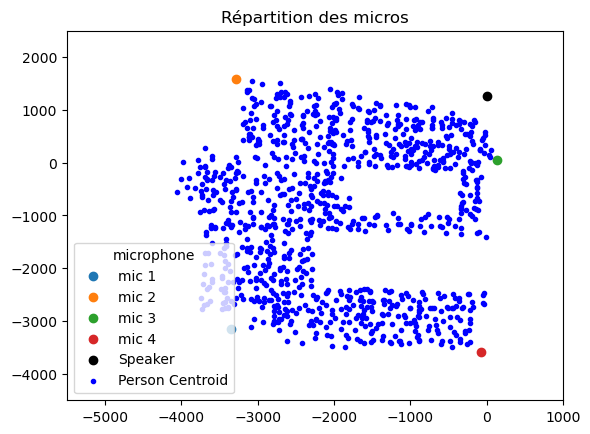

In [18]:
mic_height = 50.3125
feet = 12
y_tile = 23.5
x_tile = 11 +7/8

camera_origin_location = np.array([-6*x_tile-5.75, -y_tile, 45+13/16])*25.4

mic_1 = np.array([-11*x_tile - 1, -5*y_tile - 6-3/8, mic_height]) * 25.4 
mic_4= np.array([-11*x_tile + 1.25 + 1/16, 2.5*y_tile+3.75, mic_height]) * 25.4
mic_6 = np.array([5+3/8, 2+1/8, mic_height]) * 25.4
mic_9 = np.array([-3, -6*y_tile - 0.5, mic_height]) * 25.4


mic_xyzs = np.stack((mic_1,mic_4, mic_6, mic_9),axis=0)

SPEAKER_BOTTOM_RIGHT_Y = (1200.15 + 1196.975 + 1206.5)/ 3
SPEAKER_BOTTOM_RIGHT_X = (88.9 + 107.95 + 101.6) / 3
SPEAKER_BOTTOM_LEFT_Y = (1327.15 + 1311.55712764 + 1317.625) / 3
SPEAKER_BOTTOM_LEFT_X = - 76.98583188

speaker_xyz_bottom_right = np.array([SPEAKER_BOTTOM_RIGHT_X, SPEAKER_BOTTOM_RIGHT_Y, 44.5*25.4])
speaker_xyz_bottom_left = np.array([SPEAKER_BOTTOM_LEFT_X, SPEAKER_BOTTOM_LEFT_Y, 44.5*25.4])
speaker_xyz_top_right = np.array([SPEAKER_BOTTOM_RIGHT_X, SPEAKER_BOTTOM_RIGHT_Y, (44.5+17)*25.4])
speaker_xyz_top_left = np.array([SPEAKER_BOTTOM_LEFT_X, SPEAKER_BOTTOM_LEFT_Y, (44.5+17)*25.4])
speaker_xyz = (speaker_xyz_bottom_right+speaker_xyz_bottom_left+speaker_xyz_top_right+speaker_xyz_top_left)/4


walls = None
x_min = - 4000
x_max = 500
y_min = -4000
y_max = 2000


## affichier la disposition des microphones.
for idx, mic in enumerate(mic_xyzs):
    plt.scatter(mic[0], mic[1], label=f'mic {idx+1}')

plt.scatter(speaker_xyz[0], speaker_xyz[1], color='black', label='Speaker')


plt.scatter(centroid[:, 0], centroid[:, 1], label='Person Centroid', c='b', marker='.')

plt.title("Répartition des micros")
plt.xlim([-5500, 1000])
plt.ylim([-4500, 2500])
plt.legend(loc="lower left", title="microphone")
plt.show()

### Featurisation 
- Spectogram


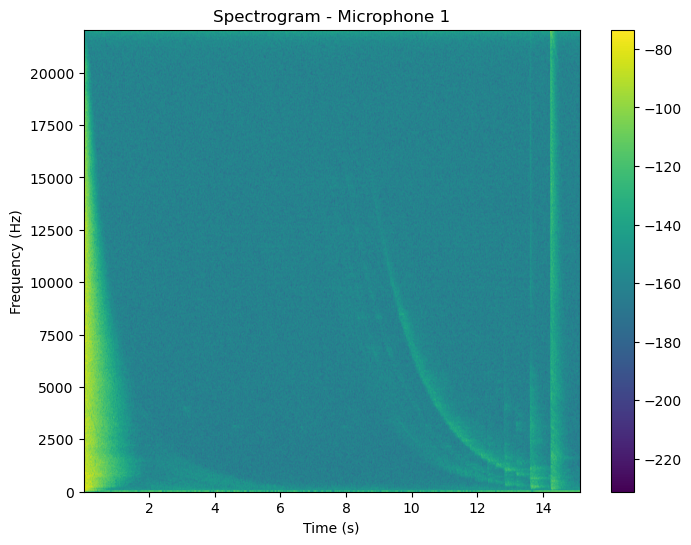

In [23]:
i = 0  # Index de l'enregistrement (0 pour le premier enregistrement)
j = 0 

# Get the signal for the ith recording and the jth microphone
signal = deconvoled[i, j, :]
    
# Create a new figure and axis for each subplot
fig, ax = plt.subplots(figsize=(8, 6))
    
# Compute and plot the spectrogram
spec, freq, t, im = ax.specgram(signal, NFFT=1024, Fs=44100, noverlap=900)
    
# Set labels and title
ax.set_xlabel('Time (s)')
ax.set_ylabel('Frequency (Hz)')
ax.set_title(f'Spectrogram - Microphone {j+1}')
    
# Add colorbar
plt.colorbar(im, ax=ax)
    
# Show the plot
plt.show()

- RMS (Root Mean Square):
The Root Mean Square (RMS) is a statistical measure used to calculate the effective value or magnitude of a set of values

In [24]:
def rms(y): # https://stackoverflow.com/questions/40963659/root-mean-square-of-a-function-in-python
    return np.sqrt(np.mean(y**2))

def rms_over_n_partitions(y, n):
    array_len = len(y)
    # Compute the length of each fraction
    fraction_len = array_len // n
    # Compute RMS for each fraction of the array
    rms_fractions = []
    for i in range(n):
        start_index = i * fraction_len
        end_index = (i + 1) * fraction_len if i < n - 1 else array_len
        rms_fraction = np.sqrt(np.mean(y[start_index:end_index]**2))
        rms_fractions.append(rms_fraction)
    # Concatenate the results horizontally
    return np.hstack(rms_fractions)


- PCA and standardization: The standardization makes the measures in the input dataset normalized.
The PCA reduces the number of datas from 667200 to 100 (n_components)

In [25]:
n_components = 100


# Init scaler and PCA
scaler = StandardScaler()
pca = PCA(n_components = n_components)

# Change the shape of the input to allow PCA
reshaped_deconvoled = deconvoled.reshape((deconvoled.shape[0], -1))

# Do PCA
pca_deconvoled = pca.fit_transform(reshaped_deconvoled)

# Scale input
scaled_deconvoled = scaler.fit_transform(pca_deconvoled)

### Model 
### Linear Regression 


### Using 'raw' datas
If you use this cell, the whole data from dataset will be used for Linear Regression

In [28]:
# Data from first cell np.load('...../Human1/deconvoled_trim.npy')  
features = deconvoled  

### Using datas then extract feature using RMS
If you use this cell, the whole data from dataset will be used.
Then the Root Mean Squared (RMS) formula will be applied to it.
This will reduce the whole sampling to an unique scalar.

By default, the number of values kept is set to 2. 
Please change this number in the cell just above, where "rms_over_n_partitions" function is defined.

In [40]:
n = 2  # Number of fractions, change this number
# Calculate RMS levels for each sample along the last axis
rms_levels = np.apply_along_axis(rms_over_n_partitions, axis=2, arr=deconvoled, n=n)
#use for classic RMS
# rms_levels = np.apply_along_axis(rms, axis=2, arr=deconvoled ) 

# Normalize the RMS levels
features = (rms_levels - np.mean(rms_levels, axis=0)) / np.std(rms_levels, axis=0)

### Using datas with PCA
If you use this cell, the whole data from dataset will be used.
Then, a PCA Linear dimensionality reduction using Singular Value Decomposition of the data to a lower dimensional space will be applied.


In [26]:
features = scaled_deconvoled

We now have a set of features, and a set of labels (loaded in the first cells).
We can then use the Linear Regression model to make predictions.

In [44]:
labels = centroids

# Classical approach of a Linear Regression model base on all the RAW DATA

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Reshape the RMS levels data to have the correct shape
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)

# Train a linear regression model for each coordinate separately 
regressor_x = LinearRegression()
print("model is fitting for x coordinates")
regressor_x.fit(X_train_reshaped, y_train[:, 0])  # Train for x-coordinate

regressor_y = LinearRegression()
print("model is fitting for y coordinates")
regressor_y.fit(X_train_reshaped, y_train[:, 1])  # Train for y-coordinate

# Reshape X_test to have only two dimensions
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)

# Make predictions on test set
y_pred_x = regressor_x.predict(X_test_reshaped)
y_pred_y = regressor_y.predict(X_test_reshaped)


# Select 10 random indices from the test set
random_indices = random.sample(range(len(y_test)), 3)

# Combine x and y predictions into coordinates
y_pred = np.column_stack((y_pred_x, y_pred_y))


# Calculate Euclidean distance between predicted and actual coordinates
errors = np.sqrt(np.sum((y_pred - y_test)**2, axis=1))
mean_error = np.mean(errors)
print(f'\nMean localization error: {mean_error:.3f} mm')

model is fitting for x coordinates
model is fitting for y coordinates

Mean localization error: 411.744 mm


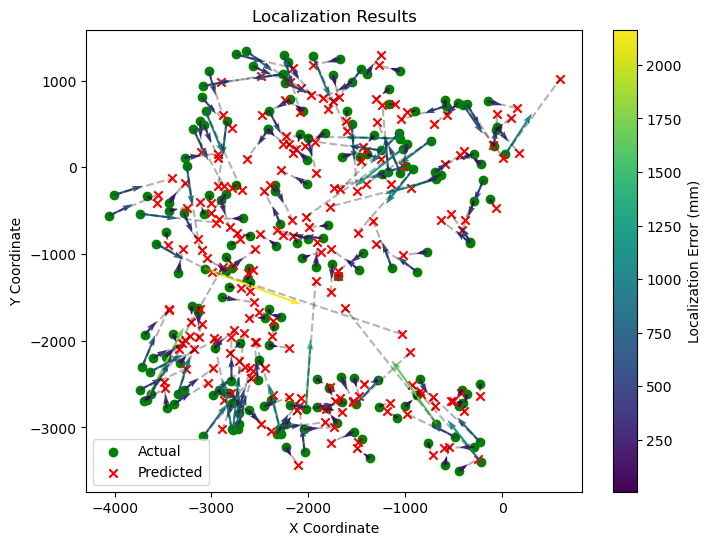

In [45]:
import matplotlib.pyplot as plt

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the actual coordinates (ground truth)
ax.scatter(y_test[:, 0], y_test[:, 1], label='Actual', color='g', marker='o')

# Plot the predicted coordinates
ax.scatter(y_pred[:, 0], y_pred[:, 1], label='Predicted', color='r', marker='x')

# Draw lines connecting the actual and predicted coordinates
for i in range(len(y_test)):
    ax.plot([y_test[i, 0], y_pred[i, 0]], [y_test[i, 1], y_pred[i, 1]], color='k', linestyle='--', alpha=0.3)

# Calculate the localization errors
errors = np.sqrt(np.sum((y_pred - y_test)**2, axis=1))

# Plot the localization errors as quiver arrows
ax.quiver(y_test[:, 0], y_test[:, 1], y_pred[:, 0] - y_test[:, 0], y_pred[:, 1] - y_test[:, 1], errors, cmap='viridis')

# Set axis labels and title
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_title('Localization Results')

# Add a colorbar for the localization errors
cbar = plt.colorbar(ax.collections[-1], ax=ax)
cbar.set_label('Localization Error (mm)')

# Add a legend
ax.legend()

# Show the plot
plt.show()

### Knn
- Trains and use the Knn to predict a coordinates pair as an output from a single measure.
- Display a pretty plot to make the results easily readables -> Links the Ground truth to the predicted coordinates (points with same color).


Mean localization error: 620.469 mm (0.620 m)


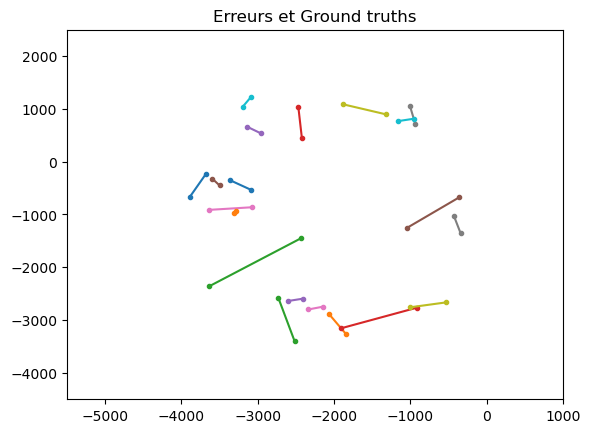

In [29]:
# Split the input and output into train and test sets
X_train, X_test, y_train, y_test = train_test_split(scaled_deconvoled, centroids, test_size=0.2)

# Init the Knn regressor
regressor = KNeighborsRegressor(n_neighbors=2)
regressor.fit(X_train, y_train)

# Make predictions on test set
y_pred = regressor.predict(X_test)

# Calculate Euclidean distance between predicted and actual coordinates
errors = np.sqrt(np.sum((y_pred - y_test)**2, axis=1))
mean_error = np.mean(errors)
print(f'\nMean localization error: {mean_error:.3f} mm ({(mean_error/1000):.3f} m)')

# Display n distances in a pretty graph
for i in range(20):
    plt.plot([y_pred[i][0], y_test[i][0]], [y_pred[i][1], y_test[i][1]], marker = '.')

plt.title("Erreurs et Ground truths")
plt.xlim([-5500, 1000])
plt.ylim([-4500, 2500])
plt.show()
